In [1]:
import datetime
import numpy as np
import pandas as pd
from pydmd import HODMD
from pydmd.preprocessing import hankel_preprocessing
from matplotlib import pyplot as plt
from src.datasource import YahooDataSource
from src.prediction import PredictionModeling
from src.bayesianopt import bayesianOpt
from src.utils import buy_signal_plots,trade_strategy
from src.utils import find_cointegrated_pairs,get_top_k_pairs,get_cointergrated_coeff
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

c:\Users\aayus\Documents\GitHub\SpreadPrediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Extraction

In [41]:
# Extract the Data from the Yahoo Data Source
start_date = datetime.datetime(2019, 3, 29)
end_date = datetime.datetime(2024, 3, 29)
tickers  =  ['SPY','AAPL','ADBE','EBAY','MSFT','QCOM',
                 'HPQ','JNPR','AMD','IBM']
columns =   ["High","Close","Low","Volume"]
ds = YahooDataSource(start_date,end_date,tickers,columns)

In [42]:
# Get only Close column data
df_pair_search = ds.get_data_by_column_tickers(columns=["Close"],tickers=-1)

In [43]:
df_pair_search.head(n=5)
scores, pvalues, pairs = find_cointegrated_pairs(df_pair_search)

top_pairs = get_top_k_pairs(pairs,5)
print("Top pairs",top_pairs)

# Get first pair
tickers = ds.get_tickers(top_pairs[0][0])
print("Top ticker",tickers)

Top pairs [(('AMD_Close', 'MSFT_Close'), 0.01801041697282686)]
Top ticker ['AMD', 'MSFT']


In [48]:
first_series = 'MSFT_Close'
second_series =  'AMD_Close'

In [49]:
# Gather High, Low ,Close , Volume of selected stocks
columns = ["High","Close","Low","Volume"]
df_raw = ds.get_data_by_column_tickers(columns=columns,tickers=tickers)

In [50]:
df_raw

,MSFT_High,MSFT_Close,MSFT_Low,MSFT_Volume,AMD_High,AMD_Close,AMD_Low,AMD_Volume
0,112.425129,112.064064,111.132886,25399800,25.730000,25.520000,25.250000,53502800
1,113.175760,113.090240,112.216078,22789100,26.559999,26.360001,25.830000,63000300
2,113.527323,113.251770,112.615145,18142300,26.799999,26.750000,26.090000,53358800
3,114.430001,113.992920,113.213774,22860700,29.950001,29.020000,27.879999,197650500
4,114.239965,113.413307,112.482129,20112800,29.389999,29.090000,28.610001,82191100
...,...,...,...,...,...,...,...,...
1254,429.086027,427.968048,425.302872,17636500,180.759995,179.649994,175.050003,57832100
1255,426.640459,422.098633,420.850883,18060500,182.800003,178.630005,172.000000,71935300
1256,425.222990,420.890808,420.591360,16725600,182.600006,177.869995,176.330002,65322400
1257,423.685786,420.671204,418.255578,16705000,181.229996,179.589996,175.399994,55685600


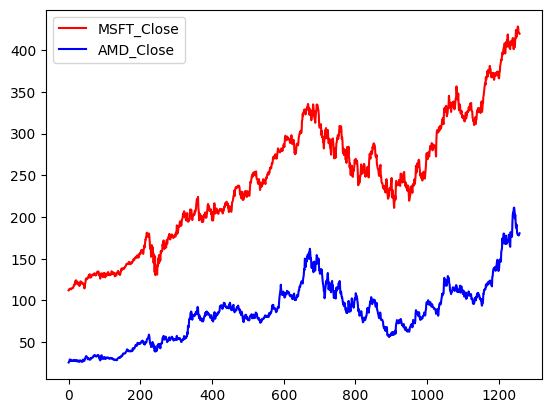

In [51]:
plt.plot(df_raw[first_series],color='r')
plt.plot(df_raw[second_series],color='b')
plt.legend([f'{first_series}',f'{second_series}'])

In [52]:
# Find ratio between co-integrated pairs
coeff = get_cointergrated_coeff(df_raw[first_series],df_raw[second_series])
print(coeff)

-1.9510277589010012


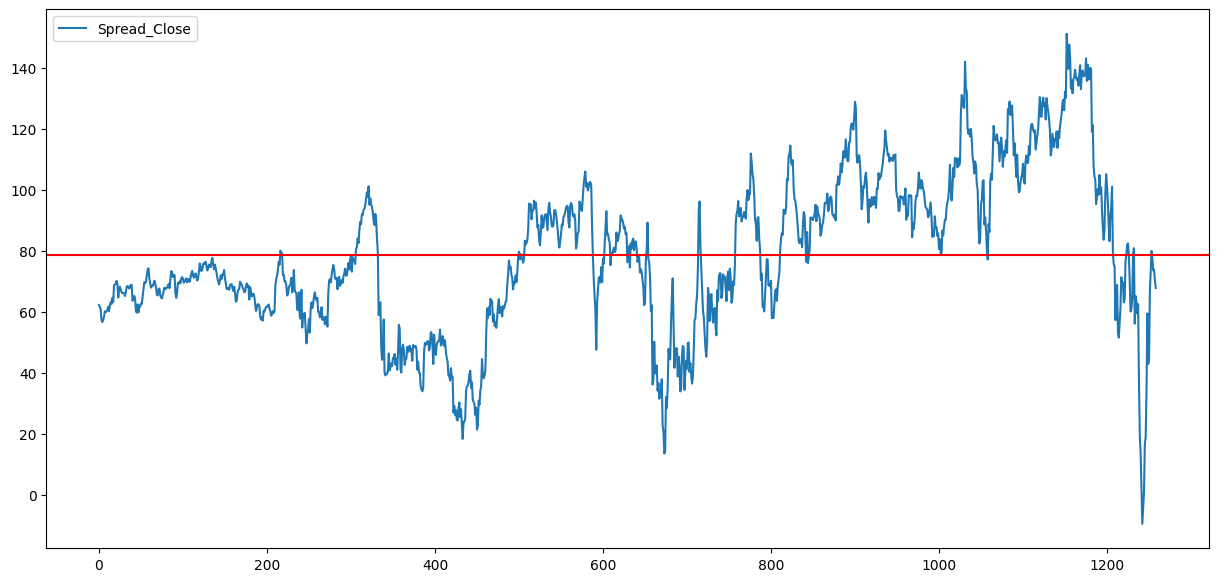

In [53]:
df_raw['Spread_Close'] = df_raw[first_series] + (df_raw[second_series] * coeff)
df_raw['Spread_Close'].plot(figsize=(15,7))
plt.axhline(df_raw['Spread_Close'].mean(),c='red')
plt.legend(['Spread_Close'])

In [54]:
pm = PredictionModeling(df_raw,"Spread_Close",0.60,1)

In [55]:
pm.add_arima_forecast("Spread_Close",order=(1,1,0))

In [56]:
pm.add_dmd_forecast("Spread_Close",svd_rank=0)

In [59]:
pm.data.head()

,MSFT_High,MSFT_Close,MSFT_Low,MSFT_Volume,AMD_High,AMD_Close,AMD_Low,AMD_Volume,Spread_Close,Spread_Close_Actual_fore_perod_1,Spread_Close_Actual_value_fore_perod_1,Spread_Close_Actual_mean_fore_perod_1,Spread_Close_ARIMA_forecast_1,Spread_Close_ARIMA_forecasts_1,Spread_Close_DMD_forecast_1,Spread_Close_DMD_forecasts_1
0,112.425129,112.064064,111.132886,25399800,25.730000,25.520000,25.250000,53502800,62.273835,[61.66114756307239],61.661148,61.661148,NaN,NaN,NaN,NaN
1,113.175760,113.090240,112.216078,22789100,26.559999,26.360001,25.830000,63000300,61.661148,[61.06177746892947],61.061777,61.061777,NaN,NaN,NaN,NaN
2,113.527323,113.251770,112.615145,18142300,26.799999,26.750000,26.090000,53358800,61.061777,[57.374093465458316],57.374093,57.374093,NaN,NaN,NaN,NaN
3,114.430001,113.992920,113.213774,22860700,29.950001,29.020000,27.879999,197650500,57.374093,[56.65790938580807],56.657909,56.657909,NaN,NaN,NaN,NaN
4,114.239965,113.413307,112.482129,20112800,29.389999,29.090000,28.610001,82191100,56.657909,[57.37610944552971],57.376109,57.376109,NaN,NaN,NaN,NaN


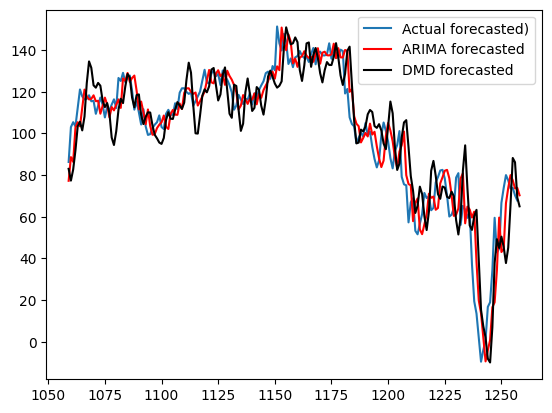

In [60]:
plt.plot(pm.data["Spread_Close_Actual_value_fore_perod_1"][-200:])
plt.plot(pm.data["Spread_Close_ARIMA_forecast_1"][-200:],color='r')
plt.plot(pm.data["Spread_Close_DMD_forecast_1"][-200:],color='k')
plt.legend(["Actual forecasted)","ARIMA forecasted","DMD forecasted"])

In [61]:
pm.data

,MSFT_High,MSFT_Close,MSFT_Low,MSFT_Volume,AMD_High,AMD_Close,AMD_Low,AMD_Volume,Spread_Close,Spread_Close_Actual_fore_perod_1,Spread_Close_Actual_value_fore_perod_1,Spread_Close_Actual_mean_fore_perod_1,Spread_Close_ARIMA_forecast_1,Spread_Close_ARIMA_forecasts_1,Spread_Close_DMD_forecast_1,Spread_Close_DMD_forecasts_1
0,112.425129,112.064064,111.132886,25399800,25.730000,25.520000,25.250000,53502800,62.273835,[61.66114756307239],61.661148,61.661148,NaN,NaN,NaN,NaN
1,113.175760,113.090240,112.216078,22789100,26.559999,26.360001,25.830000,63000300,61.661148,[61.06177746892947],61.061777,61.061777,NaN,NaN,NaN,NaN
2,113.527323,113.251770,112.615145,18142300,26.799999,26.750000,26.090000,53358800,61.061777,[57.374093465458316],57.374093,57.374093,NaN,NaN,NaN,NaN
3,114.430001,113.992920,113.213774,22860700,29.950001,29.020000,27.879999,197650500,57.374093,[56.65790938580807],56.657909,56.657909,NaN,NaN,NaN,NaN
4,114.239965,113.413307,112.482129,20112800,29.389999,29.090000,28.610001,82191100,56.657909,[57.37610944552971],57.376109,57.376109,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,429.086027,427.968048,425.302872,17636500,180.759995,179.649994,175.050003,57832100,77.465923,[73.58653471351141],73.586535,73.586535,79.969164,[79.96916354582275],65.385592,[65.3855916745518]
1255,426.640459,422.098633,420.850883,18060500,182.800003,178.630005,172.000000,71935300,73.586535,[73.8615101562504],73.861510,73.861510,77.474556,[77.4745561172069],88.201856,[88.20185587165078]
1256,425.222990,420.890808,420.591360,16725600,182.600006,177.869995,176.330002,65322400,73.861510,[70.2861355371275],70.286136,70.286136,73.598613,[73.59861316792977],86.144941,[86.14494066640216]
1257,423.685786,420.671204,418.255578,16705000,181.229996,179.589996,175.399994,55685600,70.286136,[67.82148297512708],67.821483,67.821483,73.860645,[73.8606451478465],69.231911,[69.23191075125129]


In [62]:
pm.data[:907]

,MSFT_High,MSFT_Close,MSFT_Low,MSFT_Volume,AMD_High,AMD_Close,AMD_Low,AMD_Volume,Spread_Close,Spread_Close_Actual_fore_perod_1,Spread_Close_Actual_value_fore_perod_1,Spread_Close_Actual_mean_fore_perod_1,Spread_Close_ARIMA_forecast_1,Spread_Close_ARIMA_forecasts_1,Spread_Close_DMD_forecast_1,Spread_Close_DMD_forecasts_1
0,112.425129,112.064064,111.132886,25399800,25.730000,25.520000,25.250000,53502800,62.273835,[61.66114756307239],61.661148,61.661148,NaN,NaN,NaN,NaN
1,113.175760,113.090240,112.216078,22789100,26.559999,26.360001,25.830000,63000300,61.661148,[61.06177746892947],61.061777,61.061777,NaN,NaN,NaN,NaN
2,113.527323,113.251770,112.615145,18142300,26.799999,26.750000,26.090000,53358800,61.061777,[57.374093465458316],57.374093,57.374093,NaN,NaN,NaN,NaN
3,114.430001,113.992920,113.213774,22860700,29.950001,29.020000,27.879999,197650500,57.374093,[56.65790938580807],56.657909,56.657909,NaN,NaN,NaN,NaN
4,114.239965,113.413307,112.482129,20112800,29.389999,29.090000,28.610001,82191100,56.657909,[57.37610944552971],57.376109,57.376109,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,234.683718,227.809647,226.568758,82543200,61.770000,59.730000,59.150002,79761600,111.274759,[108.97876678394906],108.978767,108.978767,126.949744,[126.94974358530567],129.530128,[129.53012780985782]
903,230.143676,223.308990,222.353709,40424600,62.720001,58.599998,58.509998,83871400,108.978767,[111.30734506540142],111.307345,111.307345,111.424260,[111.42425997011098],137.584718,[137.5847182773941]
904,233.009506,232.290573,222.619603,40647700,62.349998,62.009998,58.919998,78198600,111.307345,[111.42861570213167],111.428616,111.428616,108.995740,[108.99573999227042],125.296062,[125.29606249697332]
905,231.355000,228.607346,227.642207,28357300,61.860001,60.060001,59.529999,73274100,111.428616,[108.30912743897416],108.309127,108.309127,111.289434,[111.28943404686095],109.688407,[109.68840717055551]


# Data Prepareation of Hyperparameter Tuning for Trading Strategy

In [63]:
total_length =(len(pm.data) - pm.train_end_index)-1
train_size = 0.70
length_param_training = int((len(pm.data) - pm.train_end_index)*0.70)

In [64]:
test_data = pm.data[[first_series,second_series,"Spread_Close","Spread_Close_Actual_value_fore_perod_1","Spread_Close_ARIMA_forecast_1","Spread_Close_DMD_forecast_1"]][pm.train_end_index:-1]

In [65]:
spread_actual_val = test_data["Spread_Close_Actual_value_fore_perod_1"][:length_param_training]
spread_naive_val= test_data["Spread_Close"][:length_param_training]
spread_ARIMA_val = test_data["Spread_Close_ARIMA_forecast_1"][:length_param_training]
spread_DMD_val = test_data["Spread_Close_DMD_forecast_1"][:length_param_training]
S1_val = test_data[first_series][:length_param_training]
S2_val = test_data[second_series][:length_param_training]
spread_actual_test = test_data["Spread_Close_Actual_value_fore_perod_1"][length_param_training:]
spread_naive_test= test_data["Spread_Close"][length_param_training:]
spread_ARIMA_test = test_data["Spread_Close_ARIMA_forecast_1"][length_param_training:]
spread_DMD_test = test_data["Spread_Close_DMD_forecast_1"][length_param_training:]
S1_test = test_data[first_series][length_param_training:]
S2_test = test_data[second_series][length_param_training:]

In [123]:
45*4000*6

1080000

# Define set of Hyper parameters

In [104]:
sell_treshold_params = np.linspace(0,4,20)
buy_threshold_params = np.linspace(0,-4,20)
clear_threshold_params = np.linspace(0,0.5,10)
window1_param = np.arange(10,100,2)
window2_param = np.arange(1,7,1)
window_param = list(zip(window1_param,window2_param))

param_grid = { 'window1':window1_param,
              'window2':window2_param,
              "sell_threshold":sell_treshold_params,
              "buy_threshold":buy_threshold_params,
              "clear_threshold":clear_threshold_params }
config_dict = {"num_iteration":150}

In [101]:
buy_threshold_params

array([ 0.        , -0.21052632, -0.42105263, -0.63157895, -0.84210526,
       -1.05263158, -1.26315789, -1.47368421, -1.68421053, -1.89473684,
       -2.10526316, -2.31578947, -2.52631579, -2.73684211, -2.94736842,
       -3.15789474, -3.36842105, -3.57894737, -3.78947368, -4.        ])

#  Trading Strategy using Actual Spread (Forecasted) 

Best score: 824909.3275564577: 100%|██████████| 150/150 [04:49<00:00,  1.93s/it]


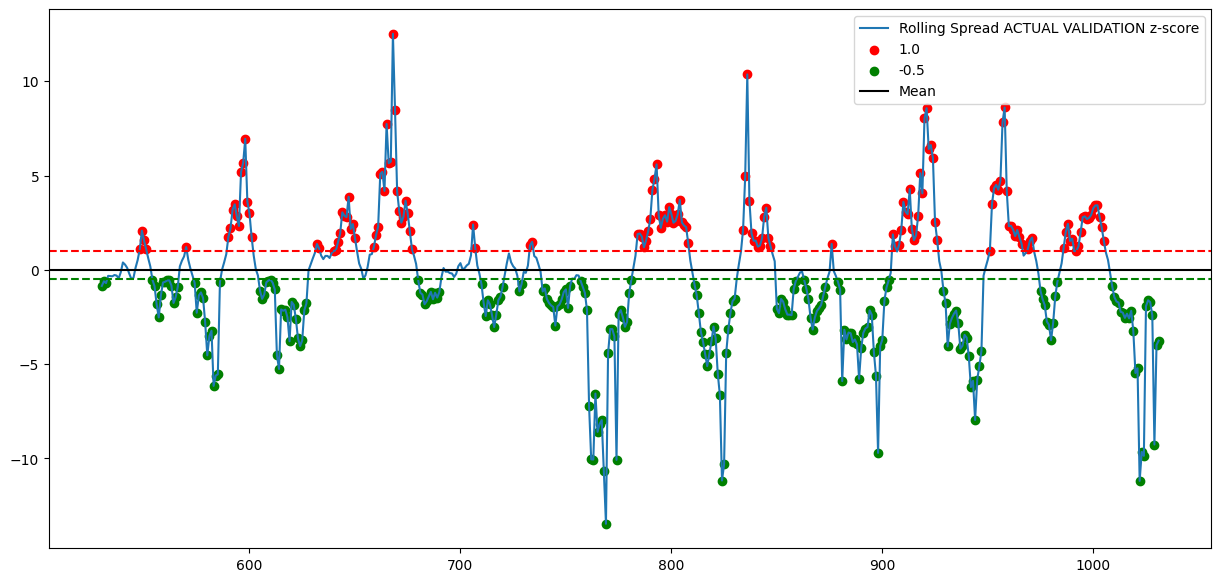

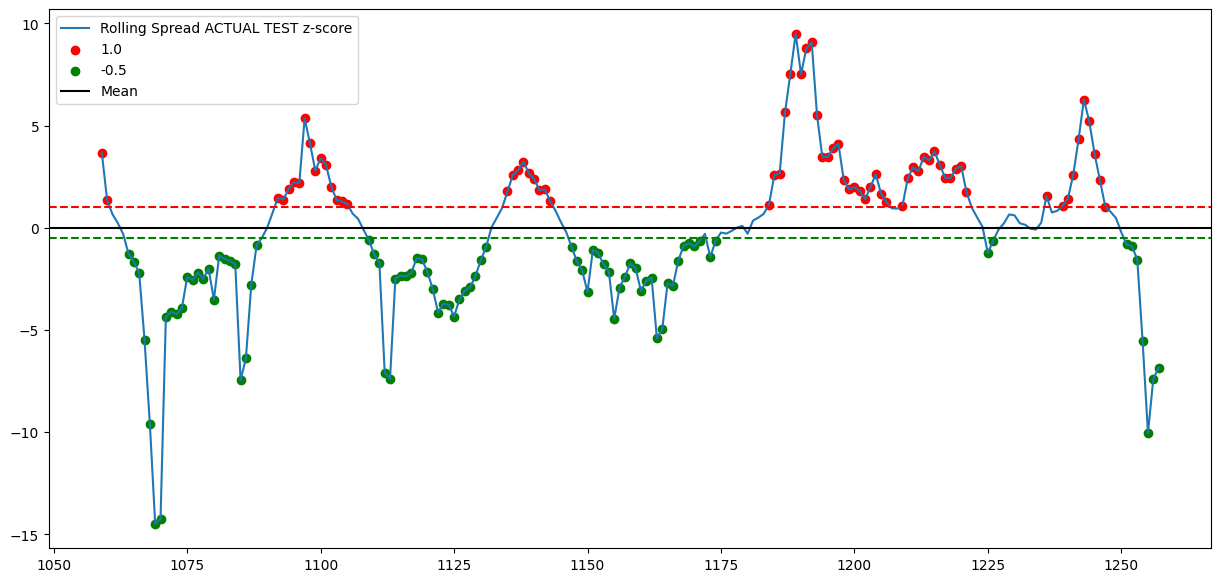

Optimal Parameters {'buy_threshold': -0.5, 'clear_threshold': 0.0, 'sell_threshold': 1.0, 'window1': 28, 'window2': 5}
Money on validation data 824909.3275564577
Money on test data 346698.1296776228


In [67]:
# Optimize the Parameters using Validation data
byopt = bayesianOpt()
params = byopt.optimize(spread_actual_val,S1_val,S2_val,param_grid,config_dict)

window1 = byopt.optimize_results["best_params"]["window1"]
window2 = byopt.optimize_results["best_params"]["window2"]
sell_threshold = byopt.optimize_results["best_params"]["sell_threshold"]
buy_threshold = byopt.optimize_results["best_params"]["buy_threshold"]
clear_threshold = byopt.optimize_results["best_params"]["clear_threshold"]


buy_signal_plots(spread_actual_val,S1_val,S2_val,window1,window2,sell_threshold,buy_threshold,label="ACTUAL VALIDATION")
buy_signal_plots(spread_actual_test,S1_test,S2_test,window1,window2,sell_threshold,buy_threshold,label="ACTUAL TEST")

money_val = trade_strategy(S1_val,S2_val,spread_actual_val,window1,window2,sell_threshold,buy_threshold,clear_threshold)

# Run the algorithm on test data
money_test = trade_strategy(S1_test,S2_test,spread_actual_test,window1,window2,sell_threshold,buy_threshold,clear_threshold)

print("Optimal Parameters",byopt.optimize_results["best_params"])
print("Money on validation data",money_val)
print("Money on test data",money_test)


In [31]:
money_val = trade_strategy(S1_test,S2_test,spread_actual_test,window1,window2,1,-1,clear_threshold)

In [32]:
money_val

-69593.36965780478

# Trading Strategy using Trading Strategy using Actual Spread  

Best score: 797453.556292051: 100%|██████████| 150/150 [01:30<00:00,  1.65it/s] 

{'buy_threshold': 0.0, 'clear_threshold': 0.1111111111111111, 'sell_threshold': 3.789473684210526, 'window1': 92, 'window2': 3}


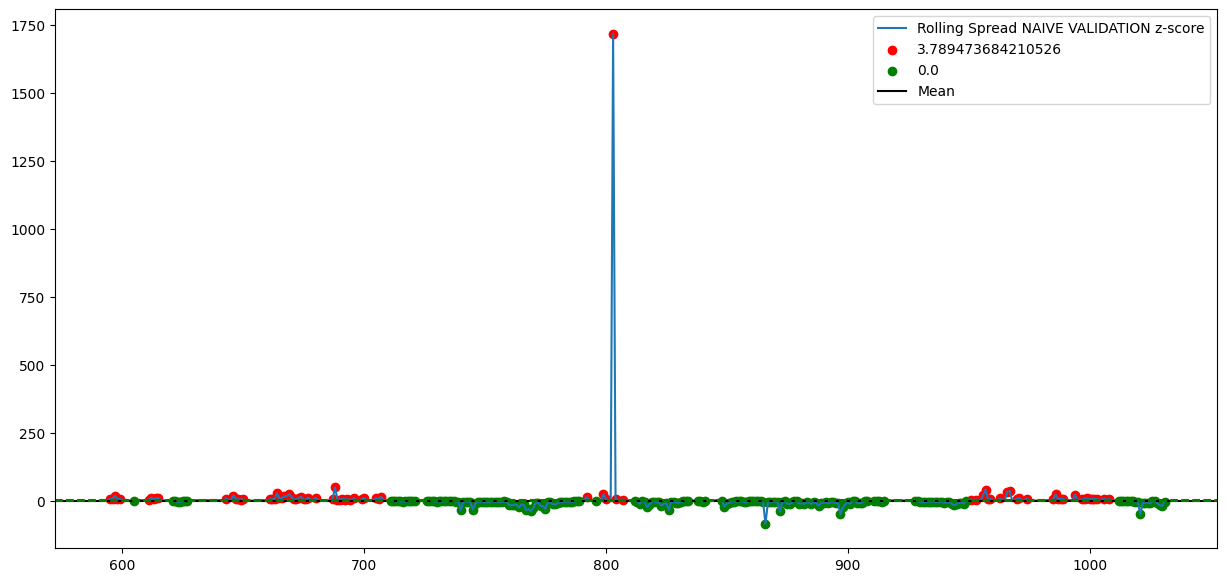

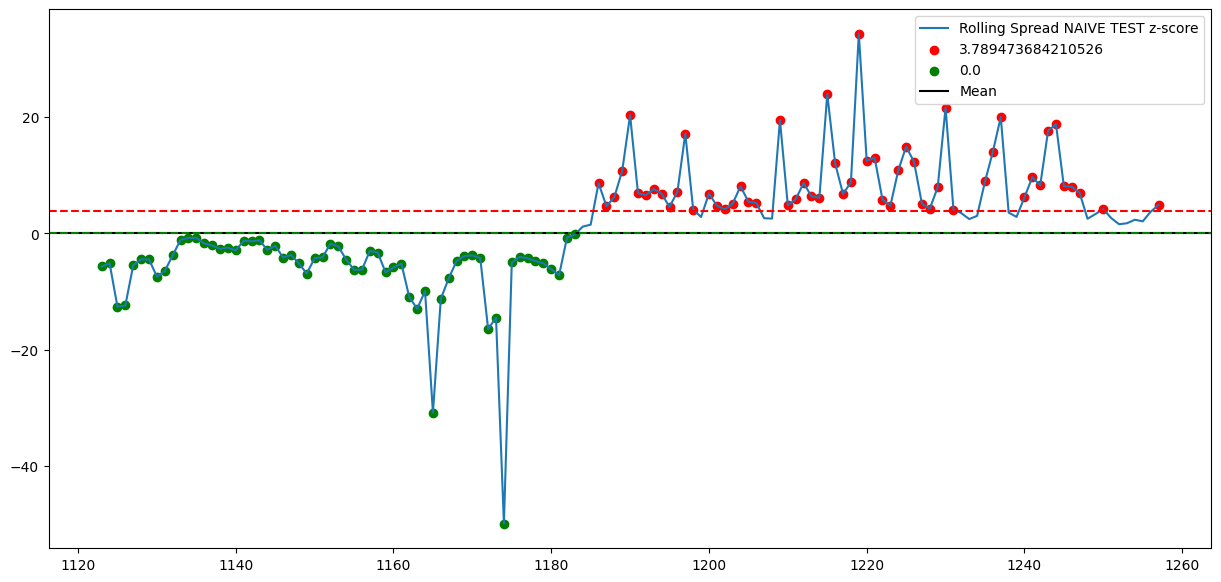

Optimal Parameters {'buy_threshold': 0.0, 'clear_threshold': 0.1111111111111111, 'sell_threshold': 3.789473684210526, 'window1': 92, 'window2': 3}
Money on validation data 797453.556292051
Money on test data 275799.18063384545


In [105]:

byopt = bayesianOpt()
params = byopt.optimize(spread_naive_val,S1_val,S2_val,param_grid,config_dict)
print(byopt.optimize_results["best_params"])
window1 = byopt.optimize_results["best_params"]["window1"]
window2 = byopt.optimize_results["best_params"]["window2"]
sell_threshold = byopt.optimize_results["best_params"]["sell_threshold"]
buy_threshold = byopt.optimize_results["best_params"]["buy_threshold"]
clear_threshold = byopt.optimize_results["best_params"]["clear_threshold"]


buy_signal_plots(spread_naive_val,S1_val,S2_val,window1,window2,sell_threshold,buy_threshold,label="NAIVE VALIDATION")
buy_signal_plots(spread_naive_test,S1_test,S2_test,window1,window2,sell_threshold,buy_threshold,label="NAIVE TEST")

money_val = trade_strategy(S1_val,S2_val,spread_naive_val,window1,window2,sell_threshold,buy_threshold,clear_threshold)
money_test = trade_strategy(S1_test,S2_test,spread_naive_test,window1,window2,sell_threshold,buy_threshold,clear_threshold)

print("Optimal Parameters",byopt.optimize_results["best_params"])
print("Money on validation data",money_val)
print("Money on test data",money_test)


# Trading Strategy using Trading Strategy using ARIMA

Best score: 1372626.4390794113: 100%|██████████| 150/150 [01:35<00:00,  1.57it/s]

{'buy_threshold': -0.42105263157894735, 'clear_threshold': 0.0, 'sell_threshold': 4.0, 'window1': 66, 'window2': 6}


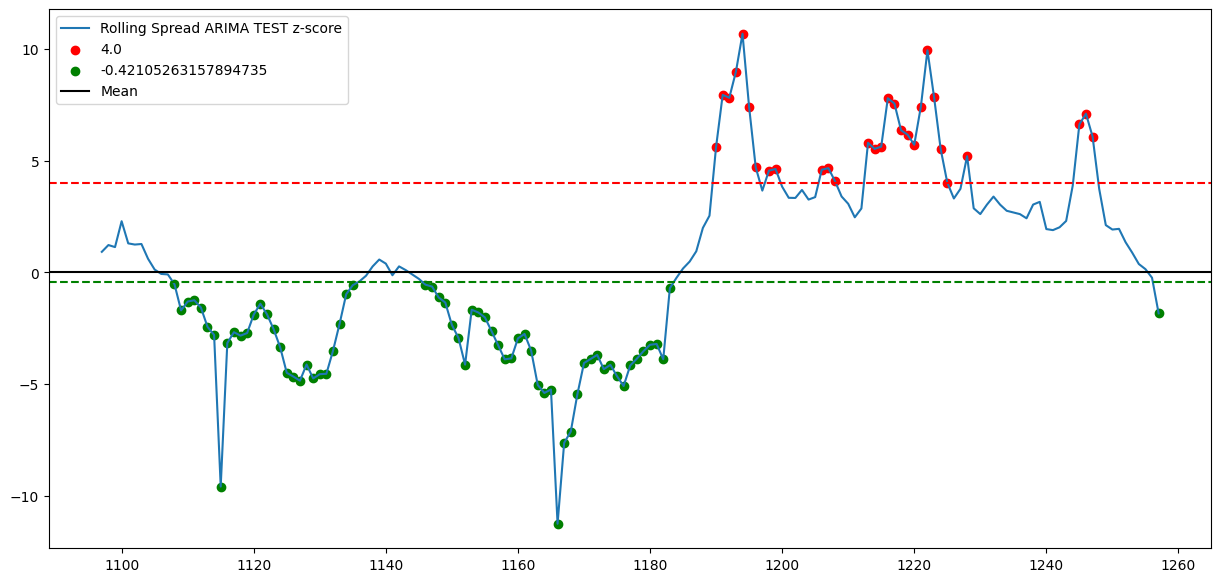

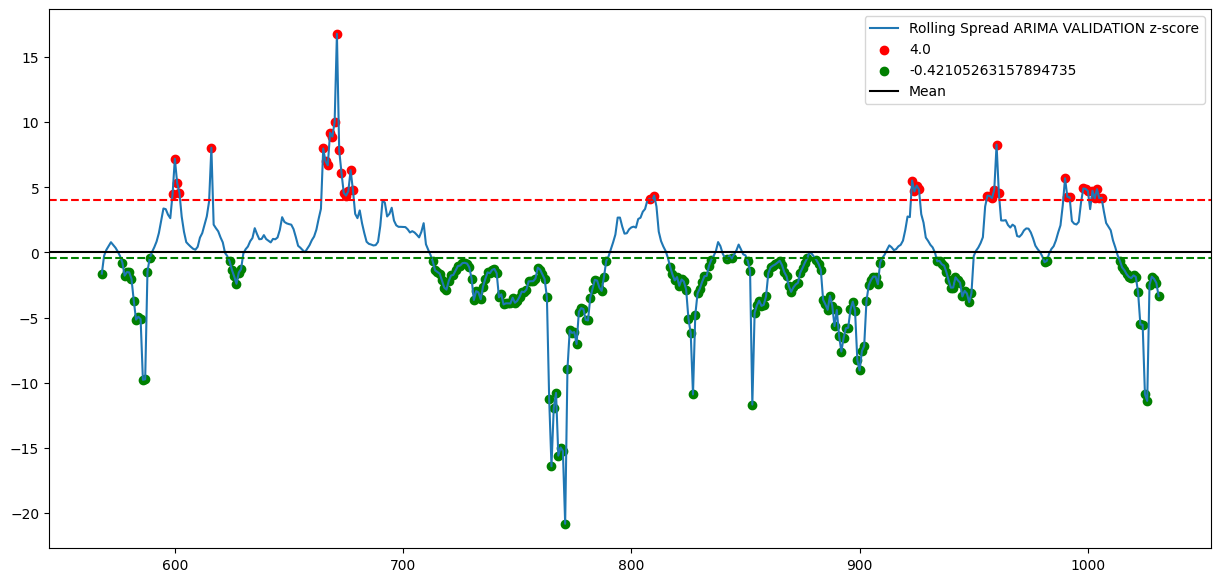

Optimal Parameters {'buy_threshold': -0.42105263157894735, 'clear_threshold': 0.0, 'sell_threshold': 4.0, 'window1': 66, 'window2': 6}
Money on validation data 1372626.4390794113
Money on test data 591512.945934848


In [106]:
byopt = bayesianOpt()
params = byopt.optimize(spread_ARIMA_val,S1_val,S2_val,param_grid,config_dict)
print(byopt.optimize_results["best_params"])
window1 = byopt.optimize_results["best_params"]["window1"]
window2 = byopt.optimize_results["best_params"]["window2"]
sell_threshold = byopt.optimize_results["best_params"]["sell_threshold"]
buy_threshold = byopt.optimize_results["best_params"]["buy_threshold"]
clear_threshold = byopt.optimize_results["best_params"]["clear_threshold"]

money_test = trade_strategy(S1_test,S2_test,spread_ARIMA_test,window1,window2,sell_threshold,buy_threshold,clear_threshold)
buy_signal_plots(spread_ARIMA_test,S1_test,S2_test,window1,window2,sell_threshold,buy_threshold,label="ARIMA TEST")

money_val = trade_strategy(S1_val,S2_val,spread_ARIMA_val,window1,window2,sell_threshold,buy_threshold,clear_threshold)
buy_signal_plots(spread_ARIMA_val,S1_val,S2_val,window1,window2,sell_threshold,buy_threshold,label="ARIMA VALIDATION")

print("Optimal Parameters",byopt.optimize_results["best_params"])
print("Money on validation data",money_val)
print("Money on test data",money_test)



In [117]:
money_test = trade_strategy(S1_test,S2_test,spread_ARIMA_test,45,5,2,-1,0)

In [118]:
money_test


457117.337439029

In [124]:
591512.945934848/457117.337439029

1.2940068063240873

# Trading Strategy using Dynamic Mode Decomposition

Best score: 1583481.2207628125: 100%|██████████| 150/150 [01:37<00:00,  1.54it/s]

{'buy_threshold': -0.5, 'clear_threshold': 0.0, 'sell_threshold': 1.0, 'window1': 42, 'window2': 5}


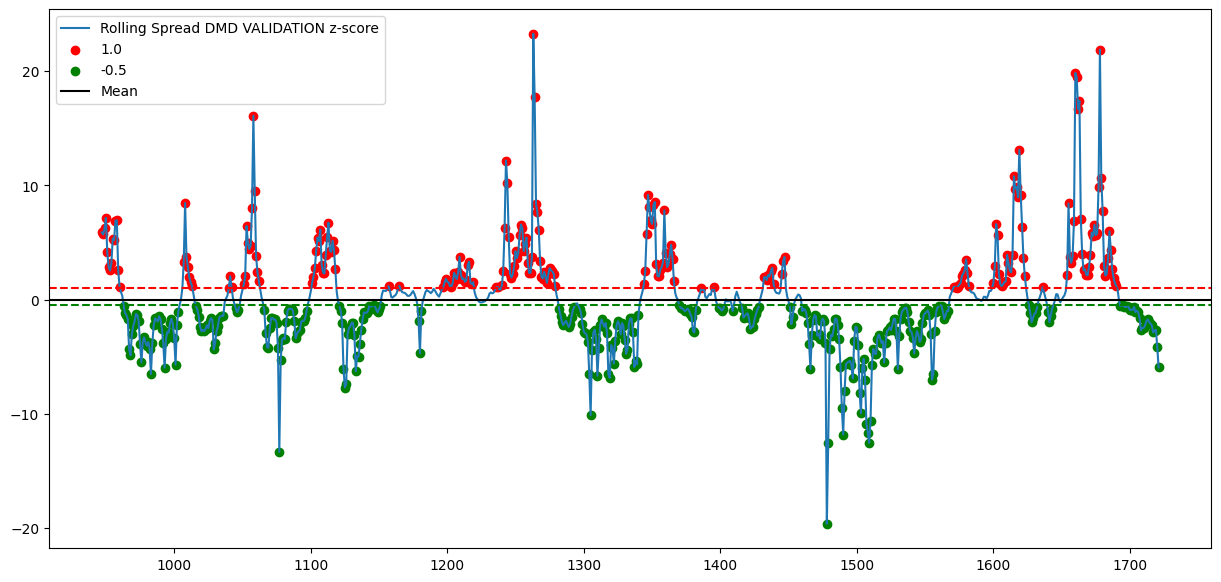

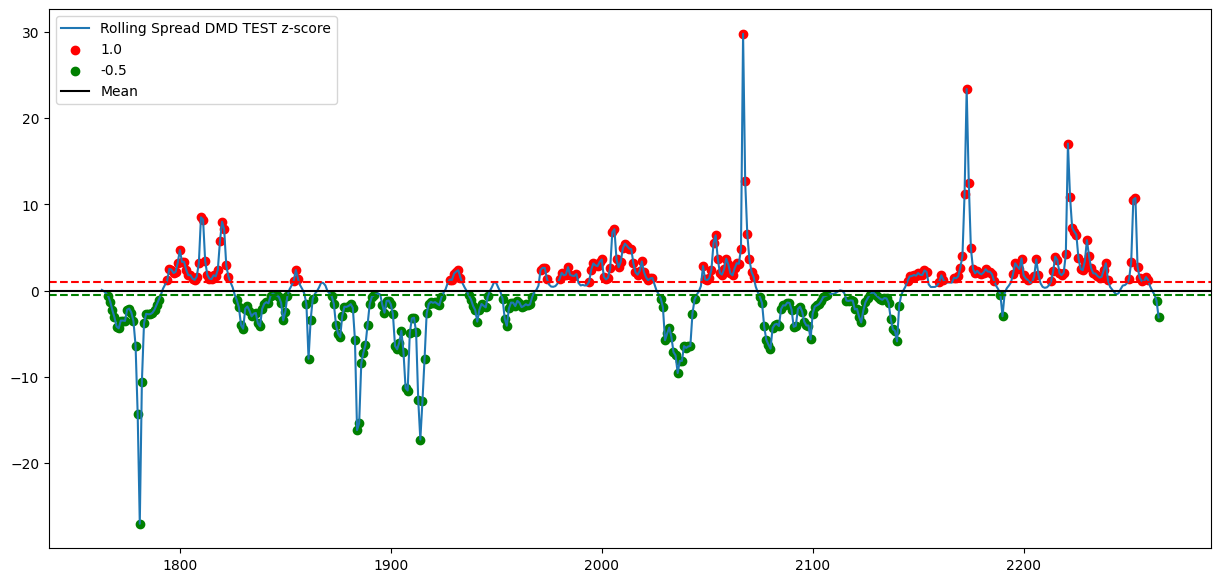

Optimal Parameters {'buy_threshold': -0.5, 'clear_threshold': 0.0, 'sell_threshold': 1.0, 'window1': 42, 'window2': 5}
Money on validation data 1583481.2207628125
Money on test data 13647.084392739576


In [35]:
byopt = bayesianOpt()
params = byopt.optimize(spread_DMD_val,S1_val,S2_val,param_grid,config_dict)
print(byopt.optimize_results["best_params"])
window1 = byopt.optimize_results["best_params"]["window1"]
window2 = byopt.optimize_results["best_params"]["window2"]
sell_threshold = byopt.optimize_results["best_params"]["sell_threshold"]
buy_threshold = byopt.optimize_results["best_params"]["buy_threshold"]
clear_threshold = byopt.optimize_results["best_params"]["clear_threshold"]

money_val = trade_strategy(S1_val,S2_val,spread_DMD_val,window1,window2,sell_threshold,buy_threshold,clear_threshold)
buy_signal_plots(spread_DMD_val,S1_val,S2_val,window1,window2,sell_threshold,buy_threshold,label="DMD VALIDATION")

money_test = trade_strategy(S1_test,S2_test,spread_DMD_test,window1,window2,sell_threshold,buy_threshold,clear_threshold)
buy_signal_plots(spread_DMD_test,S1_test,S2_test,window1,window2,sell_threshold,buy_threshold,label="DMD TEST")

print("Optimal Parameters",byopt.optimize_results["best_params"])
print("Money on validation data",money_val)
print("Money on test data",money_test)

# Parameter Initialization for ARIMA

In [106]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [107]:
result = adfuller(pm.data['Spread_Close'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.451992
p-value: 0.009309


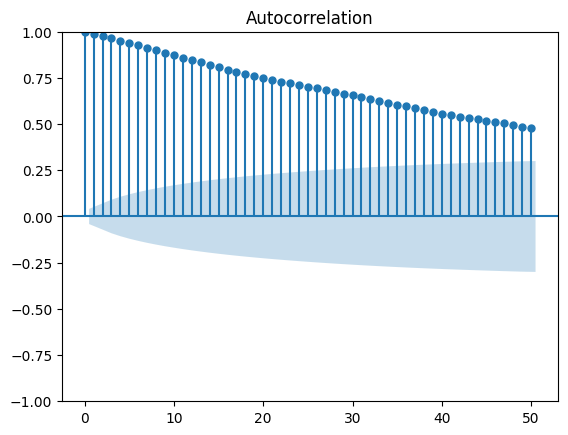

In [108]:
plot_acf(pm.data['Spread_Close'],lags=50)
plt.show()

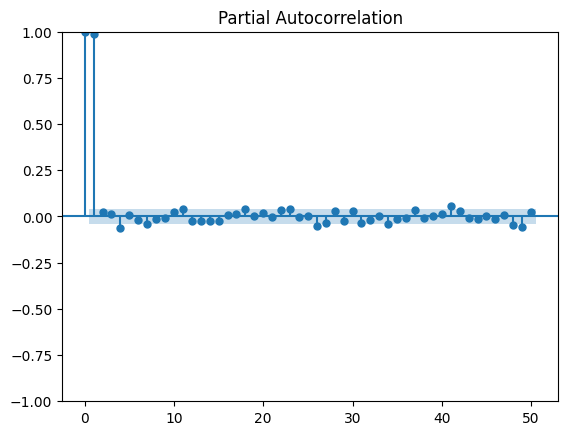

In [109]:
plot_pacf(pm.data['Spread_Close'],lags=50)
plt.show()

In [31]:
result = adfuller(pm.data['Spread_Close'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -43.978696
p-value: 0.000000


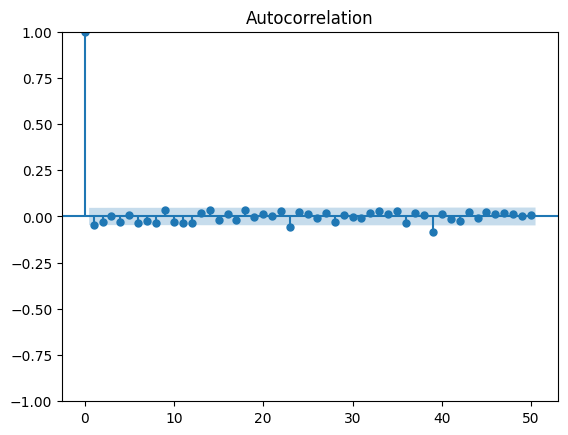

In [35]:
plot_acf(pm.data['Spread_Close'].diff().dropna(),lags=50)
plt.show()

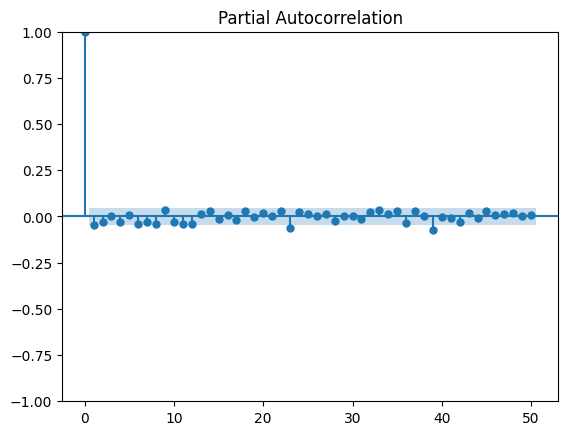

In [37]:
plot_pacf(pm.data['Spread_Close'].diff().dropna(),lags=50)
plt.show()

In [39]:

result = adfuller(pm.data['Spread_Close'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -43.978696
p-value: 0.000000


In [ ]:
# prices data 
# returns data
#  wealth -> 100000

# curr-month -> 2019-01-01
# portfoilio [12 months return (2018-01-01->2018-12-31)] optimize -> weights -> [A:0.5,B:0.3,C:0.2]
# A:50000,B:30000,C:20000
# No.A = 50000/curr_price ...

# for loop till (2019,02,01->2023-01-01)

        # curr-month -> 2019-02-01
        # wealth +=( (No.A*Price_A(2019-02-01) + ... ) 
        # portfoilio [12 months return (2018-02-01->2019-01-01)] optimize -> weights -> [A:0.7,B:0.1,C:0.2]
        # A:0.7*wealth,B:0.1*wealth,C:0.2*wealth
        # No.A = A/curr_price ...





    



In [168]:
def combine_sorted(arr1,arr2):

    arr = []
    st_1 = 0
    st_2 = 0
    while True:


        if ((st_1 < len(arr1)) and (st_2 < len(arr2))):
            if (arr1[st_1] >arr2[st_2]) :
                arr.append(arr2[st_2])
                st_2 += 1
            else:
                arr.append(arr1[st_1])
                st_1 += 1

        elif (st_2 >= len(arr2)) and (st_1< len(arr1)):
            arr.append(arr1[st_1])
            st_1+=1
        
        elif (st_1 >= len(arr1)) and (st_2< len(arr2)):
            arr.append(arr2[st_2])
            st_2+=1
        
        else:
            break
        
    return arr


In [169]:
arr1 = [2,6,8]
arr2  = [3,5]

In [170]:
print(combine_sorted(arr1,arr2))

[2, 3, 5, 6, 8]


In [171]:
def merge_sort(arr):

    if len(arr) ==1 :
        return arr
    else:

        arr_1 = merge_sort(arr[0:len(arr)//2])
        arr_2 = merge_sort(arr[len(arr)//2:])
        return combine_sorted(arr_1,arr_2)


In [173]:
print(merge_sort([3,2,9,8,0,-1]))

[-1, 0, 2, 3, 8, 9]
